Non-Survivors (0): 549
Survivors (1): 342
Total samples: 891
Percentage survived: 38.38%
Percentage of missing data per column:
Cabin       77.104377
Age         19.865320
Embarked     0.224467
dtype: float64
   Embarked  count  average_age
0         0    168    30.178095
1         1     77    28.032468
2         2    646    29.307663
Fitting 5 folds for each of 105 candidates, totalling 525 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

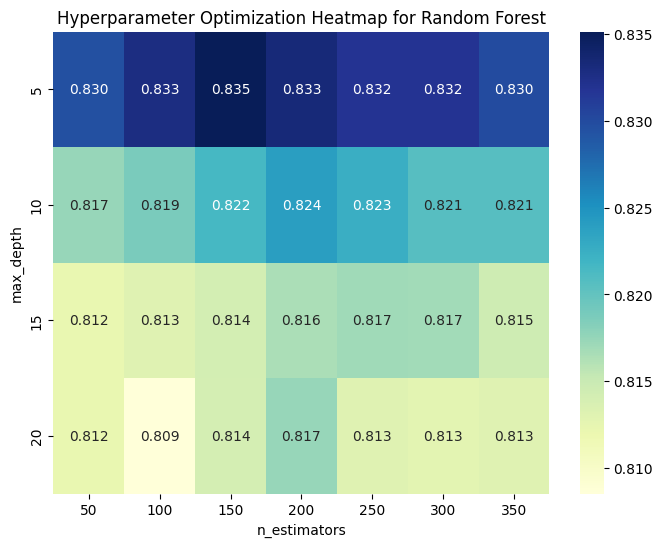

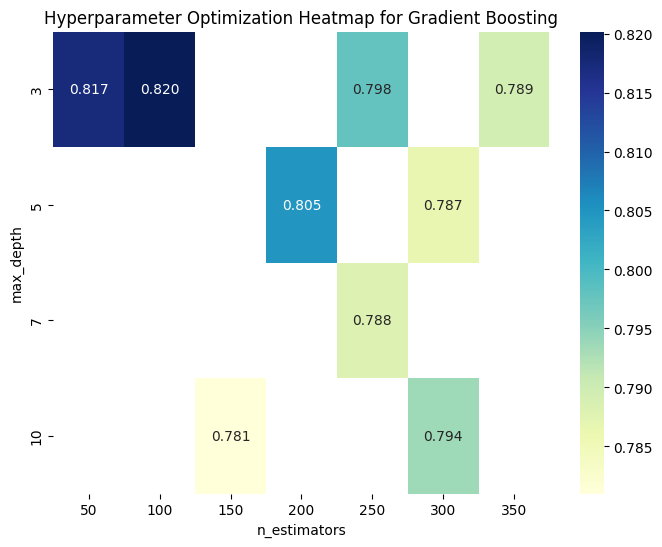

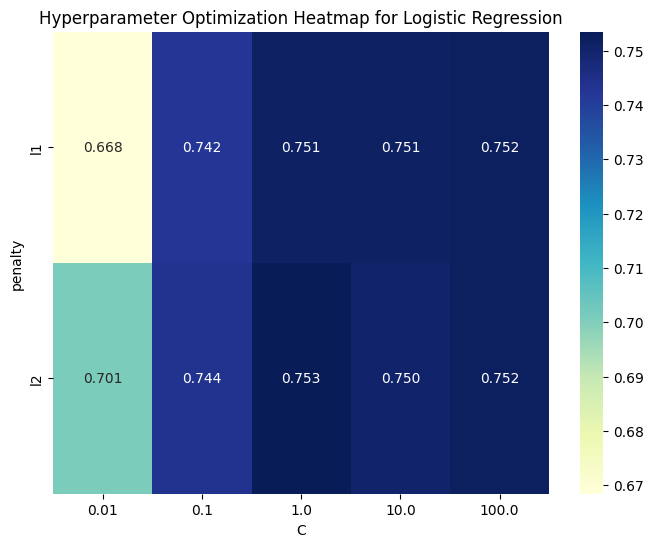

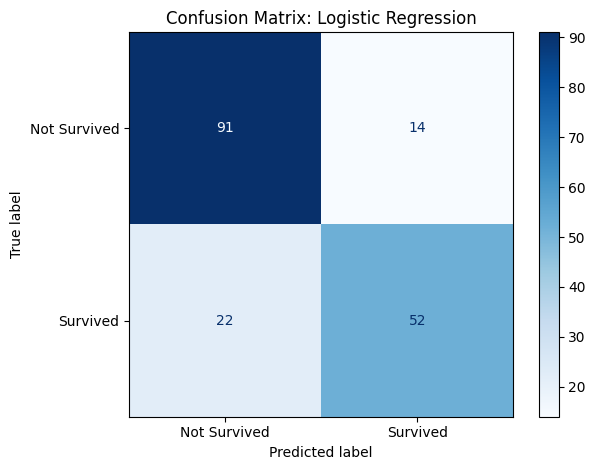

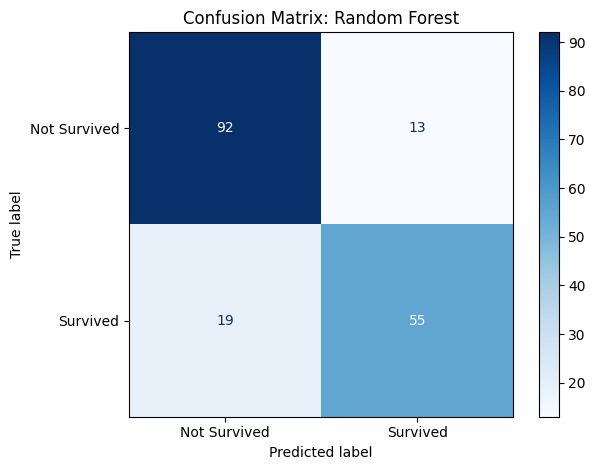

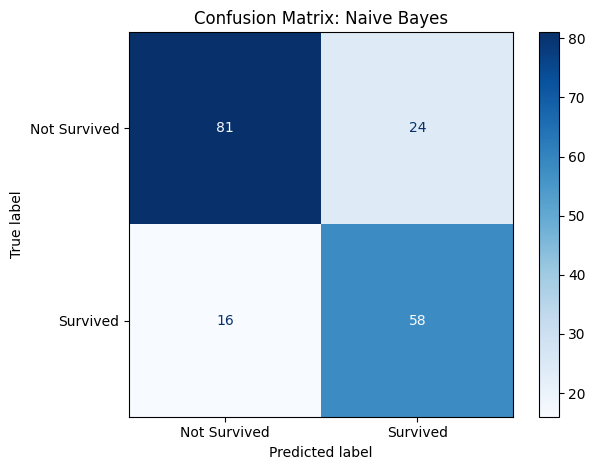

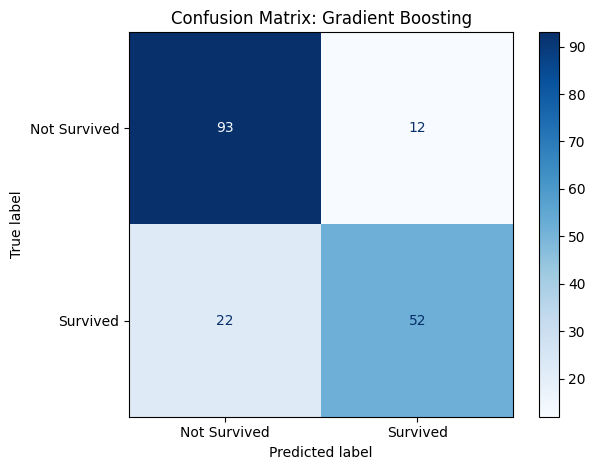

Model Performance Comparison:

                 Model  Accuracy  Precision    Recall  F1 Score  \
0  Logistic Regression  0.798883   0.787879  0.702703  0.742857   
1        Random Forest  0.821229   0.808824  0.743243  0.774648   
2          Naive Bayes  0.776536   0.707317  0.783784  0.743590   
3    Gradient Boosting  0.810056   0.812500  0.702703  0.753623   

   Cross-Val Score  
0         0.791262  
1         0.833884  
2         0.801368  
3         0.823803  


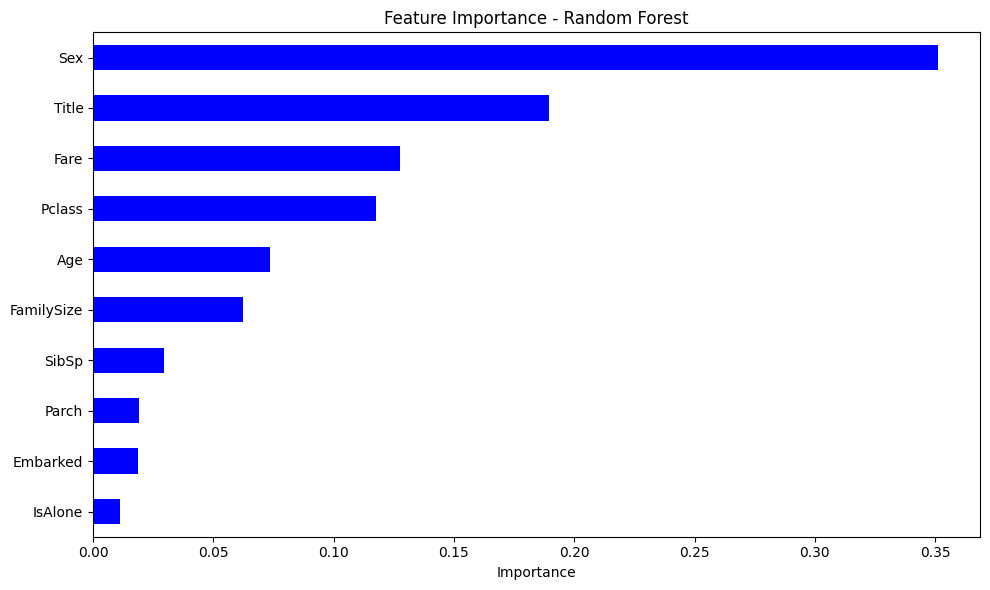

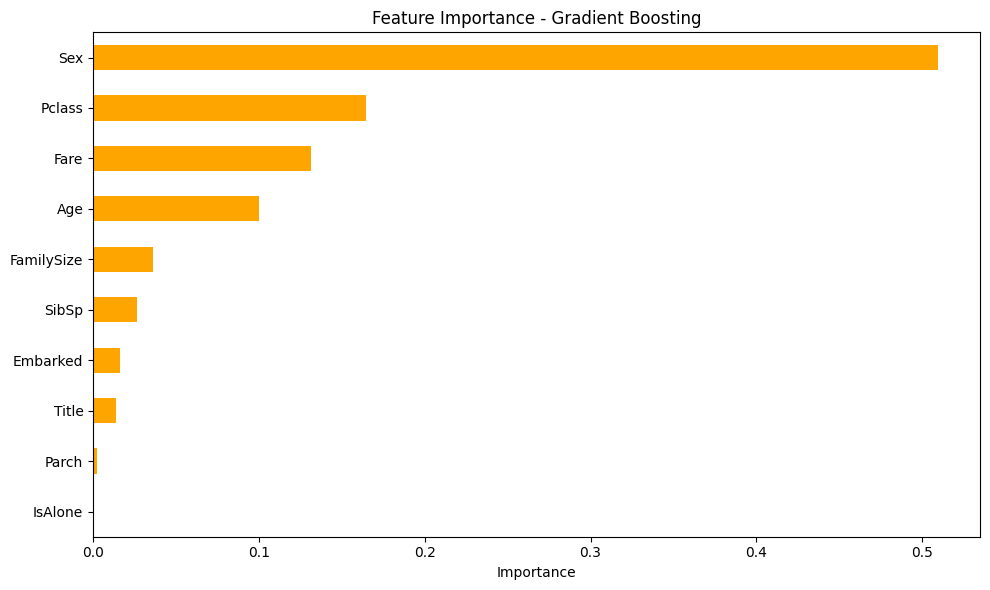

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/train.csv")

survivor_counts = df['Survived'].value_counts()
print(f"Non-Survivors (0): {survivor_counts[0]}")
print(f"Survivors (1): {survivor_counts[1]}")
print(f"Total samples: {len(df)}")
print(f"Percentage survived: {survivor_counts[1] / len(df) * 100:.2f}%")

#For finding how much data is missing in each column
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
print("Percentage of missing data per column:")
print(missing_percent)

#to drop columns that will not be used
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

#fill in missing data
df['Embarked'] = df['Embarked'].fillna('S')
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])


imputer = SimpleImputer(strategy='median')
df['Age'] = imputer.fit_transform(df[['Age']])


#Make title column
df['Title'] = pd.read_csv("/content/drive/My Drive/train.csv")['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df['Title'] = le.fit_transform(df['Title'])

#create new features
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)


#group by 'Embarked' and calculate count and average age
embarked_summary = df.groupby('Embarked').agg(count=('Embarked', 'size'),average_age=('Age', 'mean')).reset_index()
print(embarked_summary)

#split data into the features/target
X = df.drop('Survived', axis=1)
y = df['Survived']

#train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#parameter testing
param_grid_rf = {'n_estimators': [50, 100, 150, 200, 250, 300, 350], 'max_depth': [5, 10, 15, 20, None], 'min_samples_split': [2, 5, 10]}

param_grid_gb = {'n_estimators': [50, 100, 150, 200, 250, 300, 350],'learning_rate': [0.01, 0.05, 0.1, 0.2], 'max_depth': [3, 5, 7, 10]}

param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],'solver': ['liblinear', 'saga']}

#tuning the hyper params for gradient boosting, random forest, and logistic regression
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, verbose=1)
rf_grid_search.fit(X_train, y_train)

gb_random_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), param_distributions=param_grid_gb, n_iter=10, cv=5, verbose=1)
gb_random_search.fit(X_train, y_train)

lr_grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, verbose=1)
lr_grid_search.fit(X_train, y_train)

#visual heatmaps to show why best params where chosen
rf_results = pd.DataFrame(rf_grid_search.cv_results_)
pivot_rf = rf_results.pivot_table(values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_rf, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title('Random Forest: Hyperparameter Optimization Heatmap')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

gb_results = pd.DataFrame(gb_random_search.cv_results_)
pivot_gb = gb_results.pivot_table(values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_gb, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title('Gradient Boosting: Hyperparameter Optimization Heatmap')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

lr_results = pd.DataFrame(lr_grid_search.cv_results_)
pivot_lr = lr_results.pivot_table(values='mean_test_score', index='param_penalty', columns='param_C')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_lr, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title('Logistic Regression: Hyperparameter Optimization Heatmap')
plt.xlabel('C')
plt.ylabel('penalty')
plt.show()

#use the models with best hyperparameters
best_rf = rf_grid_search.best_estimator_
best_gb = gb_random_search.best_estimator_
best_lr = lr_grid_search.best_estimator_


#list of all models to compare
models = {'Logistic Regression': best_lr, 'Random Forest': best_rf, 'Naive Bayes': GaussianNB(), 'Gradient Boosting': best_gb}

#train and test models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    cv_score = cross_val_score(model, X, y, cv=5).mean()

    results.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Cross-Val Score': cv_score})

    #confusion matrix for each model based on survivor/non-survivors
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived', 'Survived'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.tight_layout()
    plt.show()

#print results for each model
results_df = pd.DataFrame(results)
print("Model Performance Comparison:\n")
print(results_df)

#feature importance plot random forest
importances_rf = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
importances_rf.plot(kind='barh', color = 'blue')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

#feature importance plot gradient boosting
importances_gb = pd.Series(best_gb.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
importances_gb.plot(kind='barh', color='orange')
plt.title("Feature Importance - Gradient Boosting")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
